In [64]:
import netCDF4 as nc
import numpy as np
import os
import matplotlib.pyplot as plt

In [65]:
output_path = '/data/nriemer/d/sf20/les_output/wrf-partmc'
output_subdir = os.path.join(output_path, 'slurm-1904245')
GO_data = nc.Dataset(os.path.join(output_subdir, 'gridded-output_020_020_00000002.nc'))

Print variable names, dimensions, and descriptions

In [66]:
for var in GO_data.variables.keys():
    try:
        descrip = GO_data[var].long_name
    except AttributeError:
        try:
            descrip = GO_data[var].description
        except AttributeError:
            descrip = 'no description'
    print(f'{var:27s}  dimensions: {str(GO_data[var][:].shape):12s} description: {descrip}  -  ')

process                      dimensions: ()           description: the process number (starting from 1) that output this data file  -  
total_processes              dimensions: ()           description: total number of processes  -  
time                         dimensions: ()           description: time elapsed since simulation start  -  
timestep                     dimensions: ()           description: current timestep size  -  
timestep_index               dimensions: ()           description: an integer that is 1 on the first timestep, 2 on the second timestep, etc.  -  
gas_species                  dimensions: (77,)        description: dummy dimension variable (no useful value) - read species names as comma-separated values from the 'names' attribute  -  
gas_mosaic_index             dimensions: (77,)        description: MOSAIC indices of gas species  -  
aero_species                 dimensions: (20,)        description: dummy dimension variable (no useful value) - read species n

In [67]:
def getParticleDiameters():
    particle_volume = (GO_data['aero_particle_mass'][:].T/GO_data['aero_density'][:].reshape(1, 20)).sum(axis=1)
    particle_diameter = np.cbrt(particle_volume*(6/np.pi))
    return particle_diameter

# getParticleMasses
particle_masses = GO_data['aero_particle_mass'][:]
# getParticleMassFracs

particle_diameters = getParticleDiameters()

Create lists for gas and aerosol species names to allow for accessing species index indirectly through species name

In [68]:
gas_species = GO_data['gas_species'].names.split(',')
aero_species = GO_data['aero_species'].names.split(',');

def getGasData(species_name):
    # get the mixing ratio column data for passed gas species name
    gas_species_index = gas_species.index(species_name)
    return GO_data['gas_mixing_ratio'][gas_species_index, :]

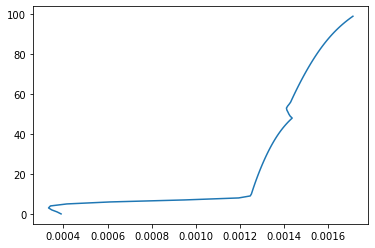

In [69]:
species_data = getGasData('OH')
plt.plot(species_data, np.arange(0, 100, 1))

The way I understand the gridded output is that all computational particles in the column are stored in the same array, however aerosol particles within a given grid cell are organized into continguous segments of the array. For instance, below we see that the particles in the lowest grid cell are at index 1 to 583. 

In [70]:
def getVertGridCellPartIndices(k):
    # return the start and end indices of the particles in the requested kth vertical 
    # grid cell
    # TODO: with this method I'm getting one less particle in the topmost grid cell
    # when I check against GO_data['n_parts'][-1].item()
    start_idx = GO_data['part_start_index'][k]
    n_parts_in_cell = GO_data['n_parts'][k].item()
    end_idx = start_idx + n_parts_in_cell
    return start_idx, end_idx

In [71]:
bin_edges = np.logspace(-8, -6, 100)
bin_logwidth = (np.log10(bin_edges[1:]) - np.log10(bin_edges[0:-1]))

def getNumberDist(particle_diam_arr):
    
    # returns array of size equal to the number of particles in the passed array
    # with elements equal to the bin number in which the particle is sorted into
    digitized = np.digitize(particle_diam_arr, bin_edges) 

    # one could use the digitized array as a map to access particles within a certain 
    # bin number range (below I'm getting particles in bins below #40 but you could
    # do both lower and upper bounds). A potentially useful extension of this would be
    # to pass upper and lower bounds in terms of particle diameters, for which the closest
    # bin edges are found and corresponding indicies, which would then be passed on to this
    # mapping as lower/upper bounds on the digitized array
    #sfc_part_diams[digitized<40]

    # get the number of particles in each bin
    bin_count = np.bincount(digitized, minlength=bin_edges.size)

    #print(bin_count.sum()) # verify the total bin count matches number of particles

    dNdlogDp = bin_count[:-1] / bin_logwidth # TODO: make sure this is actually log Dp on the denom

    return dNdlogDp


In [118]:
start_idx, end_idx = getVertGridCellPartIndices(k=0)
#start_idx, end_idx = 0, -1 #compute for all particles in column
cell_part_diams = particle_diameters[start_idx:end_idx]
cell_num_conc = getNumberDist(particle_diam_arr=cell_part_diams)

In [119]:
#start_idx, end_idx = 0, -1 #compute for all particles in column
particle_diam_arr = particle_diameters[start_idx:end_idx]
particle_mass_arr = particle_masses[:, start_idx:end_idx]
digitized = np.digitize(particle_diam_arr, bin_edges) 

# create an array of size num species x number of bins
# for each particle in particle diameter array
# add amount of each species in particle to species in bin
binned_species_mass = np.zeros((20, 100)) 
for binidx, particle in zip(digitized, particle_mass_arr.T):
    binned_species_mass[:, binidx] += particle


In [74]:
from cycler import cycler


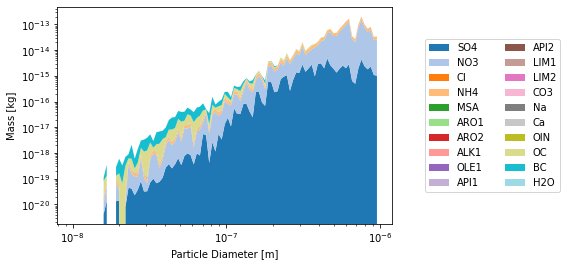

In [128]:
bin_total_mass = np.zeros((99,))
fig, ax = plt.subplots(1, 1)
plt.rcParams['axes.prop_cycle'] = cycler('color', plt.get_cmap('tab20').colors)

"""
for i in range(20):
    val = binned_species_mass[i, :]
    bin_total_mass += val
    plt.plot(bin_edges[:], bin_total_mass)
plt.xscale('log')
plt.yscale('log')
"""

# Plot the total speciated mass distribution
for i, species in enumerate(aero_species):
    species_mass_dist = binned_species_mass[i, :-1]/bin_logwidth
    bin_total_mass += species_mass_dist
    #print(bin_total_mass[50])
   #ax.plot(bin_edges[:-1], bin_total_mass, label=species)
    if i == 0:
        y_lower = ax.get_ylim()[0]
        y_lower = np.array(99*[y_lower])
    else:
        y_lower = bin_total_mass - species_mass_dist
    ax.fill_between(x=bin_edges[:-1], y1=y_lower, y2=bin_total_mass, label=species)

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Mass [kg]')
plt.xlabel('Particle Diameter [m]')
plt.legend(loc='center', bbox_to_anchor=(1.3, .5), ncol=2)

/tmp/ipykernel_54075/796252094.py:7: RuntimeWarning: invalid value encountered in divide
  species_frac = species_mass_dist/total_mass_per_bin


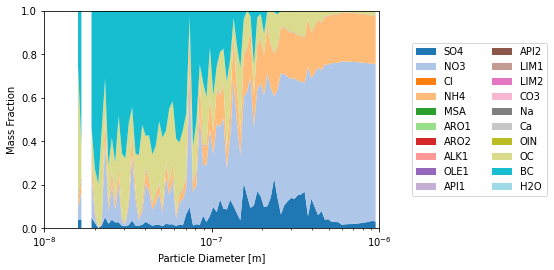

In [121]:
total_mass_per_bin = (binned_species_mass[:, :-1]/bin_logwidth).sum(axis=0)
frac_total = np.zeros((99,))
fig, ax = plt.subplots(1, 1)
# Plot the total speciated mass distribution
for i, species in enumerate(aero_species):
    species_mass_dist = binned_species_mass[i, :-1]/bin_logwidth
    species_frac = species_mass_dist/total_mass_per_bin
    frac_total += species_frac
    #print(bin_total_mass[50])
   #ax.plot(bin_edges[:-1], bin_total_mass, label=species)
    if i == 0:
        y_lower = 0
        y_lower = np.array(99*[y_lower])
    else:
        y_lower = frac_total - species_frac
    ax.fill_between(x=bin_edges[:-1], y1=y_lower, y2=frac_total, label=species)

plt.xlim(1e-8,1e-6)
plt.ylim(0, 1)
plt.xscale('log')
plt.ylabel('Mass Fraction')
plt.xlabel('Particle Diameter [m]')
plt.legend(loc='center', bbox_to_anchor=(1.3, .5), ncol=2)


In [81]:
spec = 'NH4'
GO_data['aero_density'][aero_species.index(spec)].item()

1770.0

(10, 1000)

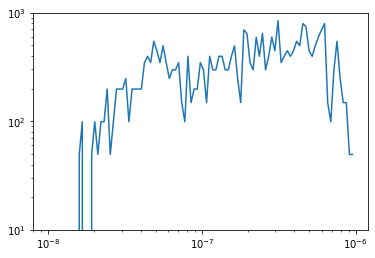

In [107]:
# the values are being plotted at the left-most edge of each bin, so technically
# using the geometric center of each bin might be better
plt.plot(bin_edges[:-1], cell_num_conc) 
plt.xscale('log')
plt.yscale('log')
plt.ylim(10, 1000)

In [83]:
GO_data['part_start_index'][:].data

array([    1,   584,  1137,  1709,  2221,  2678,  3198,  3723,  4188,
        4483,  4814,  5156,  5489,  5803,  6133,  6484,  6803,  7123,
        7453,  7777,  8084,  8443,  8780,  9126,  9440,  9784, 10138,
       10466, 10794, 11147, 11474, 11845, 12173, 12524, 12868, 13182,
       13500, 13843, 14208, 14543, 14898, 15256, 15583, 15934, 16258,
       16626, 16930, 17280, 17615, 17964, 18292, 18603, 18941, 19287,
       19619, 19937, 20264, 20600, 20925, 21274, 21590, 21879, 22207,
       22484, 22833, 23178, 23503, 23846, 24170, 24504, 24827, 25127,
       25462, 25797, 26129, 26444, 26790, 27134, 27474, 27836, 28130,
       28485, 28814, 29149, 29486, 29802, 30143, 30497, 30842, 31134,
       31474, 31832, 32149, 32467, 32786, 33108, 33437, 33777, 34088,
       34415], dtype=int32)

Confirming there are 583 particles in the lowest grid cell, the first entry of `n_parts` array is 583

In [84]:
GO_data['n_parts'][0].item()

583

In [85]:
GO_data['n_parts'][:].data

array([583, 553, 572, 512, 457, 520, 525, 465, 295, 331, 342, 333, 314,
       330, 351, 319, 320, 330, 324, 307, 359, 337, 346, 314, 344, 354,
       328, 328, 353, 327, 371, 328, 351, 344, 314, 318, 343, 365, 335,
       355, 358, 327, 351, 324, 368, 304, 350, 335, 349, 328, 311, 338,
       346, 332, 318, 327, 336, 325, 349, 316, 289, 328, 277, 349, 345,
       325, 343, 324, 334, 323, 300, 335, 335, 332, 315, 346, 344, 340,
       362, 294, 355, 329, 335, 337, 316, 341, 354, 345, 292, 340, 358,
       317, 318, 319, 322, 329, 340, 311, 327, 331], dtype=int32)

In [86]:
np.unique(GO_data['aero_water_hyst_leg'][:].data)

array([0], dtype=int32)

Show the constituent species mass (all 20 aerosol species) for each aerosol particle (all 583) in the lowest grid cell 

In [87]:
GO_data['aero_particle_mass'][:, 1:584].data

array([[1.89821768e-19, 7.36306240e-21, 2.66210989e-18, ...,
        2.18420051e-17, 3.45485758e-18, 5.30341833e-18],
       [4.19102824e-19, 3.08067324e-20, 1.76763869e-17, ...,
        4.78927849e-16, 1.52092790e-16, 1.05149655e-17],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.31865305e-19, 3.21164464e-19, 1.86026199e-18, ...,
        1.51262810e-17, 1.92463777e-18, 3.94679494e-18],
       [0.00000000e+00, 1.36494897e-19, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

So in total there are 34745 particles. However, I think in order to keep track of particles that coagulate, aerosol particles have a number of components (starting at 1 and incrementing by 1 when a coagulation event happens?). The third to last particle in the top most grid cell has two components

In [88]:
GO_data['aero_component_len'][-3:]

masked_array(data=[2, 1, 1],
             mask=False,
       fill_value=999999,
            dtype=int32)

In [89]:
GO_data['aero_component_particle_num'][-4:]

masked_array(data=[329, 329, 330, 331],
             mask=False,
       fill_value=999999,
            dtype=int32)